In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The purpose is to build a function / app that can take an address (Panel Hdg, CT) and turn it into an X Y coordinate.
Functionality should include
1) Headings 3,4,5, and later
2) Plunges by letter, or a length along the RO
3) headings 2 and 6
4) Standard CT spacing 30m
5) Options for custom spacing

The approach is to build a function that ingests a string (or a series of parameters), splits it into the components then does a lookup against known intersection coords

In order to do this it is necessary to build a DB of intersection coords.
This was chosen as it allows you to check the coords (by plotting) against the real thing up front. So the QA/QC of coords vs ground truths (DXF) are known

NB: this will require a DXF plot of the workings into plt or similar

A function will be written to build new panels out of specified
1) HDG spacing
2) CT spacing
3) Panel Name
4) Starting location (4hdg 1ct)

# Test cases
This should be tested on
- bearings of 20, 110, 200 and 290 degrees based on the main direction of the mine
- ct spacing 30
- custom spacing with 30, 45, 60, and combinations of

In [3]:
def generate_int_coords(panel, HDG, x, y, dirn, numberOfCt, spacingOfCt):
    '''
    This generates a heading worth of intersection coords
    It returns a dataframe of: Panel (str) | HDG (int) | CT (int) | x | y
    
    Based on inputs:
    panel = str
    HDG = int 3|4|5
    coords x,y (float)
    direction = bearing in degrees clockwise from (0)north
    numberOfCt = number of Ct's worth to generate (int)
    spacingOfCt = the distance between ct's along the heading float OR
                    a list with 'numberOfCt' elements with the distance between each CT, the first should be 0  
    '''
    ct_numbers = list(range(1,numberOfCt+1)) # make a list of CT numbers 
    
    if type(spacingOfCt) == list: # if the spacing is a list use it
        if len(spacingOfCt) == numberOfCt:
            ct_spacing = [0]*numberOfCt
            for e in list(range(0, numberOfCt)):
                ct_spacing[e] = sum(spacingOfCt[0:e]) # list of distances between CT
            
            
    elif type(spacingOfCt) == int: # if the spacing is a number, build a list
        ct_spacing = [0]*numberOfCt
        for e in list(range(0, numberOfCt)):
            ct_spacing[e] = e * spacingOfCt # list of distances between CT
    
    alpha = np.radians(90-dirn) # heading direction convert alpha to clockwise radians from North
    beta  = np.radians(-dirn) # ct direction to clockwise radians from North
    
    heading_offset = {1:-90,2:-60,3:-30,4:0,5:30,6:60,7:90}
    
    xs = []
    ys = []
    n = 0
    for ct in ct_numbers:
        xs.append(x + ct_spacing[n]*np.cos(alpha) + heading_offset[HDG]*np.cos(beta))
        ys.append(y + ct_spacing[n]*np.sin(alpha) + heading_offset[HDG]*np.sin(beta))
        n+=1

    df = pd.DataFrame({"Panel":numberOfCt*[panel],"HDG":HDG,"CT":ct_numbers,"x":xs,"y":ys})
    return df

def make_panel (panel, HDG, x, y, dirn, numberOfCt, spacingOfCt):
    '''
    This generates a whole panel worth of intersection coords
    It returns a dataframe of: Panel (str) | HDG (int) | CT (int) | x | y
    
    Based on inputs:
    panel = str
    HDG = list of HDG's
    coords x,y (float)
    direction = bearing in degrees clockwise from (0)north
    numberOfCt = number of Ct's worth to generate (int)
    spacingOfCt = the distance between ct's along the heading float OR
                    a list with 'numberOfCt' elements with the distance between each CT, the first should be 0  
    '''
    df = pd.DataFrame()
    for H in HDG:
        df = df.append(generate_int_coords(panel, H, x, y, dirn, numberOfCt, spacingOfCt))
        
    return df
        

Panel    9 East
HDG           2
CT            6
x           150
y            60
Name: 5, dtype: object

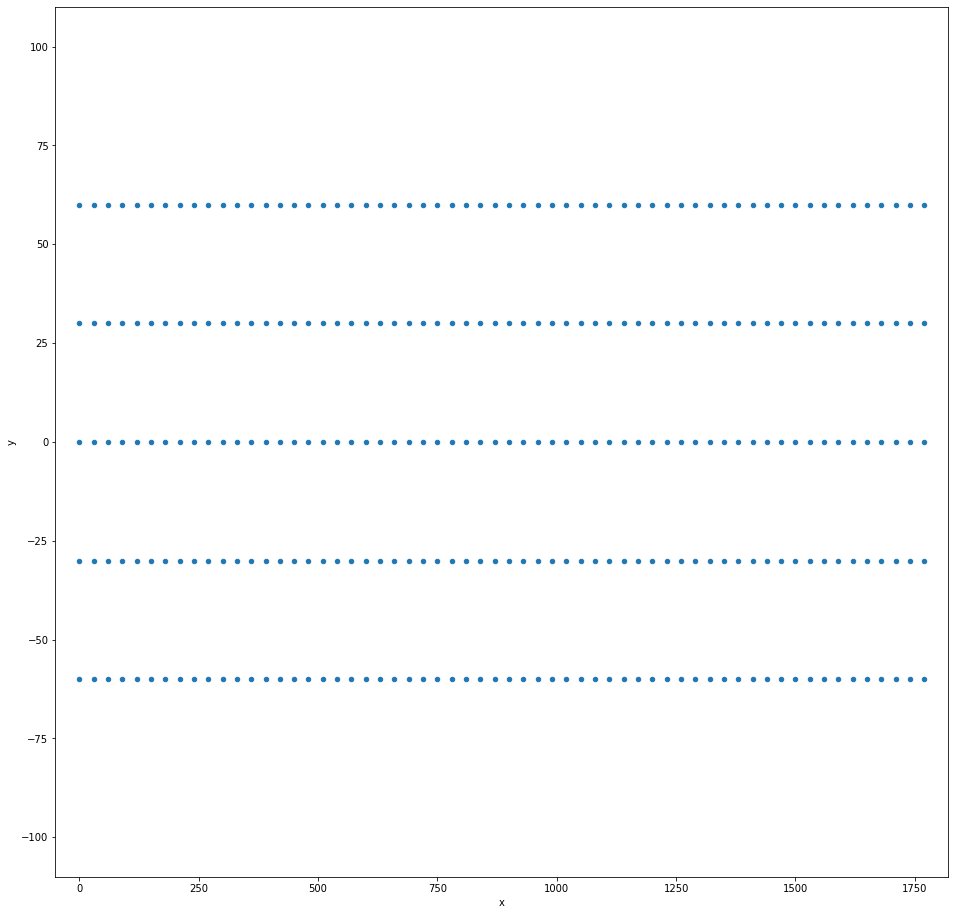

In [6]:
df = make_panel("9 East",[2,3,4,5,6],0,0,90,60,30)
limx = (min(df.x)-50,max(df.x)+50)
limy = (min(df.y)-50,max(df.y)+50)        
df.plot(kind="scatter",
       x='x',
       y='y',
       xlim = limx,
       ylim = limy,
       figsize = (16,16)
      )

df.iloc[5]

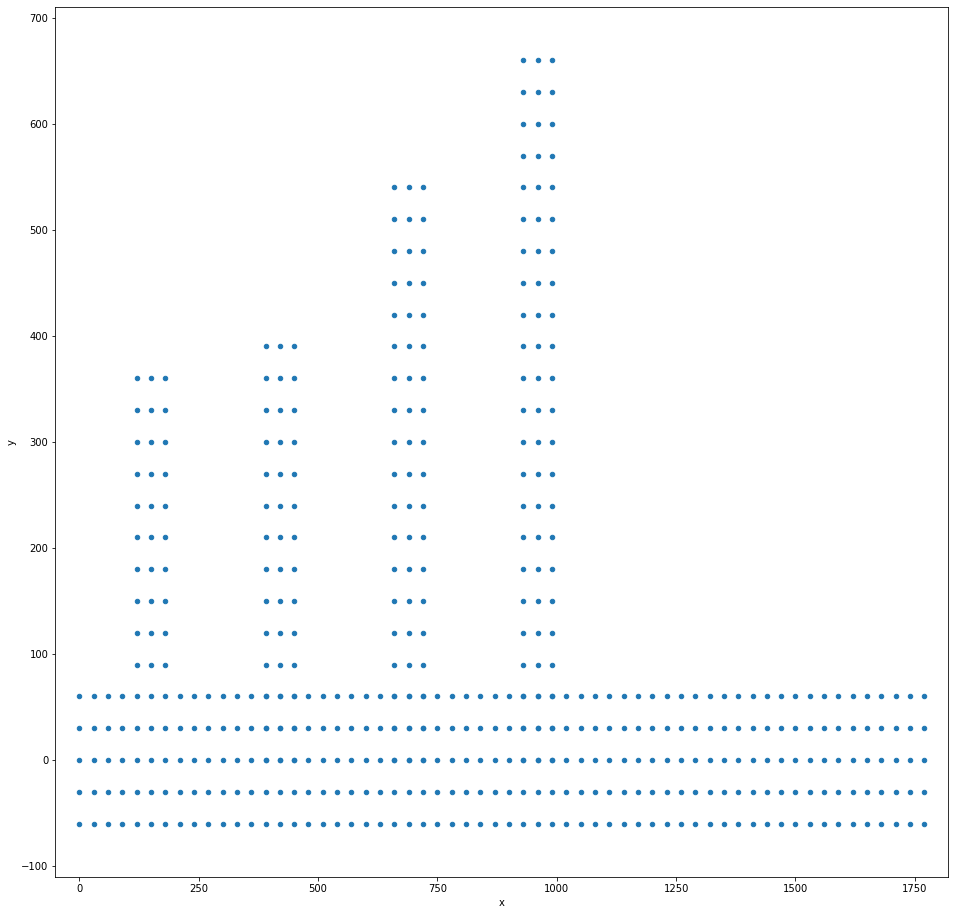

In [7]:
panels = [1110,1120,1130,1140]
starts = [(150,90),(150+270,0), (150+540,0),(150+810,0)]
lengths = [10,14,19,23]

# df = pd.DataFrame()
for p,s,l in zip(panels,starts,lengths):
    df = df.append(make_panel(p,[3,4,5],s[0],s[1],0,l,30))

limx = (min(df.x)-50,max(df.x)+50)
limy = (min(df.y)-50,max(df.y)+50)        
df.plot(kind="scatter",
       x='x',
       y='y',
       xlim = limx,
       ylim = limy,
       figsize = (16,16)
      )

In [ ]:
def unpack_address(address):
    
    address = address.upper() # make uppercase
    address = address.replace("HDG","H") # change HDG to H
    address = address.split(" ") # split at spaces
    panel = address[0] # take the first as panel ??? what about 9 East
    
    for e in address:
        if 'H' in e:
            hdg = int(e.replace('H','')) # works only on H, not hdg or Hdg
        elif 'CT' in e:
            ct = int(e.replace('CT','')) # works only in ct, not CT or Ct

    return (panel, hdg, ct)

def lookup_location (address, df):
    panel,hdg,ct = unpack_address(address)
    x = df[(df['Panel'] == panel) & (df['HDG'] == hdg) & (df['CT'] == ct)].iloc[0].x
    y = df[(df['Panel'] == panel) & (df['HDG'] == hdg) & (df['CT'] == ct)].iloc[0].y
    return x,y
    

In [ ]:
address_list = [
    "1120 Panel 4hdg 3ct",
    "1120 3H 10CT",
    "1120 5Hdg 9Ct"
]

for ad in address_list:
    print(lookup_location(ad,a))
    

In [ ]:
panel_spacing = [0]+[30]*4 + [45,60,45] + [30]*12
a = generate_int_coords("1120",3,100,150,20,20,panel_spacing)
b = generate_int_coords("1120",4,100,150,20,20,panel_spacing)
c = generate_int_coords("1120",5,100,150,20,20,panel_spacing)

a = pd.concat([a,b,c])

lims = 1000

a.plot(kind="scatter",
       x='x',
       y='y',
       xlim = (0,lims),
       ylim = (0,lims),
       figsize = (16,16)
      )

In [ ]:
a[(a['Panel'] == '1120') & (a['HDG'] == 5) & (a['CT'] == 6)].iloc[0].x

Some of the early interactive work to get the method right

In [ ]:
Panel = "1120"
CT_number = list(range(1,11)) # list of CT numbers 
CT_between = [0,30,30,45,60,30,30,30,30,30] #distances between CT
HDG = 4
n=1
dist_list=[] # make a list of the distance from 1ct to any given CT
for dist in CT_between:
    dist_list.append(sum(CT_between[0:n]))
    n+=1
    
x,y = 650,1300 #starting x,y for 4hdg 1ct for the panel
CT_width = 30
alpha = 200
alpha = np.radians(90 - alpha) #angles are anticlockwise from East, convert to clockwise from North


In [ ]:
xs = []
ys = []
n = 0
for ct in CT_number:
    xs.append(x + dist_list[n]*np.cos(alpha))
    ys.append(y + dist_list[n]*np.sin(alpha))
    n+=1

df = pd.DataFrame({"Panel":len(CT_number)*[Panel],"HDG":HDG,"CT":CT_number,"x":xs,"y":ys})
df

In [ ]:
HDG = 5
xs = []
ys = []
n = 0
for ct in CT_number:
    xs.append(df.x[n] + CT_width * np.sin(alpha))
    ys.append(df.y[n] - CT_width * np.cos(alpha))
    n+=1

df1 = pd.DataFrame({"Panel":len(CT_number)*[Panel],"HDG":HDG,"CT":CT_number,"x":xs,"y":ys})
df1

In [ ]:
HDG = 3
xs = []
ys = []
n = 0
for ct in CT_number:
    xs.append(df.x[n] - CT_width * np.sin(alpha))
    ys.append(df.y[n] + CT_width * np.cos(alpha))
    n+=1

df2 = pd.DataFrame({"Panel":len(CT_number)*[Panel],"HDG":HDG,"CT":CT_number,"x":xs,"y":ys})

In [ ]:
df3 = pd.concat([df,df1,df2])
df3.plot(kind="scatter", x="x",y="y",
       xlim=(0,1000),
       ylim=(1000,2000))

